In [1]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Video Thumbnail Generation using Gemini 1.5 Pro (API & Python SDK)

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/vision/use-cases/video-thumbnail-generation/video_thumbnail_generation.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fvision%2Fuse-cases%2Fvideo-thumbnail-generation%2Fvideo_thumbnail_generation.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Run in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/vision/use-cases/video-thumbnail-generation/video_thumbnail_generation.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/vision/use-cases/video-thumbnail-generation/video_thumbnail_generation.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>

| | |
|-|-|
|Author(s) | [Kartik Chaudhary](https://github.com/kartikgill)|

## Overview

### Gemini

Gemini is a family of generative AI models developed by Google DeepMind that is designed for multimodal use cases. The Gemini API gives you access to the Gemini models.

### Vertex AI Gemini API

The Vertex AI Gemini API provides a unified interface for interacting with Gemini models. You can interact with the Gemini API using the following methods:

- Use [Vertex AI Studio](https://cloud.google.com/generative-ai-studio) for quick testing and command generation
- Use cURL commands
- Use the Vertex AI SDK

This notebook focuses on using the **Vertex AI SDK for Python** to call the Vertex AI Gemini API.

For more information, see the [Generative AI on Vertex AI](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview) documentation.


### Objectives

In this tutorial, you will learn how to generate meaningful thumbnail images for a video using Gemini 1.5 Pro (`gemini-1.5-pro`) model.

You will complete the following tasks:

- Install the Vertex AI SDK for Python
- Use the Vertex AI Gemini API to interact with the Gemini 1.5 Pro model
    - Generate thumbnails for a Video with caption
    - Better prompting to get better thumbnails and captions

### Costs

This tutorial uses billable components of Google Cloud:

- Vertex AI

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.


## Getting Started


### Install Vertex AI SDK for Python


In [ ]:
! pip3 install --upgrade --user google-cloud-aiplatform

### Install other useful libraries

In [ ]:
! pip3 install --upgrade --user moviepy
! pip3 install --upgrade --user cloudpathlib

### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).


In [ ]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [1]:
PROJECT_ID = "kartik-first-project"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries


In [2]:
import json
import re

import matplotlib.pyplot as plt
import moviepy
from moviepy.editor import VideoFileClip
from vertexai.generative_models import GenerativeModel, Part

## Using the Gemini 1.5 Pro model

The Gemini 1.5 Pro (`gemini-1.5-pro`) model is a foundation model that performs well at a variety of multimodal tasks such as visual understanding, classification, summarization, and creating content from image, audio and video. It's adept at processing visual and text inputs such as photographs, documents, infographics, and screenshots.


### Load the Gemini 1.5 Pro model


In [3]:
model = GenerativeModel("gemini-1.5-pro")

### Sample Video path from Google Cloud Storage

#### [Click here to watch/download this video](https://cloud.google.com/vertex-ai/generative-ai/docs/prompt-gallery/samples/video_video_q_and_a_89?hl=en)

In [4]:
video_uri = "gs://sample-videofile/sample_video_google_trips.webm"

### Creating a local copy of the video for easy frame extraction

In [ ]:
!gsutil cp {video_uri} sample_video.webm

### Creating a MoviePy Clip Object (Helps in extracting frame at a given timestamp)

In [6]:
clip = VideoFileClip("sample_video.webm")

### Setting up Gemini 1.5 Pro API for thumbnail generation

In [7]:
generation_config = {
    "max_output_tokens": 8192,
    "temperature": 1,
    "top_p": 0.8,
}

### Define a function to Call Gemini API

In [8]:
def call_gemini_1_5_Pro(
    prompt: str,
    gcs_video_path: str,
    model: vertexai.generative_models.GenerativeModel,
) -> str:
    """Call Gemini 1.5 Pro API with video and prompt."""
    # creating video input for API call
    video_input = Part.from_uri(
        mime_type="video/webm",
        uri=gcs_video_path,
    )
    # calling Gemini API
    responses = model.generate_content(
        [video_input, prompt],
        generation_config=generation_config,
        stream=False,
    )
    # print(responses.text, end="")
    return responses.text

### Defining a function to parse output and display results

In [9]:
def display_results(
    response_text: str,
    clip: moviepy.video.io.VideoFileClip.VideoFileClip,
) -> None:
    """Parse json output, extract thumbnail frames and plot."""
    # cleaning up and loading json object
    response_string = re.sub("```json", "", response_text)
    response_string = re.sub("```", "", response_string)
    json_response = json.loads(response_string)

    # extracting timestamps and captions from response
    timestamps = json_response["timestamp"]
    captions = json_response["caption"]

    # Image plotting settings
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))

    # extract frame for each timestamp and plot the images
    counter = 0
    for timestamp, caption in zip(timestamps, captions):
        frame = clip.get_frame(timestamp)
        row, col = counter // 2, counter % 2
        ax[row, col].imshow(frame)
        ax[row, col].set_title(caption, fontdict={"fontsize": 9})
        counter += 1

    fig.show()

# Case 1: Using a Simple Prompt

### Writing a basic prompt for thumbnail generation

In [10]:
basic_prompt = """Generate 4 thumbnail images from the given video file with short captions.
Provide response in proper JSON format similar to following:
{
    \"timestamp\": [],
    \"caption\": []
}
"""

### calling Gemini API with our prompt and video

In [11]:
response_text = call_gemini_1_5_Pro(
    prompt=basic_prompt,
    gcs_video_path=video_uri,
    model=model,
)

### showing JSON output from Gemini

In [12]:
print(response_text)

```json
{
    "timestamp": [
        "00:00",
        "00:13",
        "00:37",
        "01:00"
    ],
    "caption": [
        "A woman is packing for a trip.",
        "The woman is looking for her hotel.",
        "The woman is at the hotel reception.",
        "The woman is visiting a park."
    ]
}
```


### displaying thumbnail results with captions

In [ ]:
display_results(response_text, clip)

# Case 2: Using an Advanced Prompt

### Writing an advanced prompt for better thumbnail generation

In [53]:
advanced_prompt = """You are an expert in video content creation and content marketing.
You have the ability to find best thumbnails from a video and provide meaningful and short and catchy captions for them.
Your task is to find the best 4 thumbnails from a given video along with short, and meaningful captions that is good for marketing.
Consider the following rules while generating thubmnails:

- Thumbnail should have clear focus on the key objects and people, less focus on background
- Thumbnail image should be high quality and bright, avoid blurry images
- Thumbnail image and caption together tell a story
- Thumbnail caption is good for marketing

Provide response in a proper JSON format similar to following:
{
    \"timestamp\": [],
    \"caption\": []
}
"""

### calling Gemini API

In [54]:
response_text2 = call_gemini_1_5_Pro(
    prompt=advanced_prompt,
    gcs_video_path=video_uri,
    model=model,
)

### showing JSON output string

In [55]:
print(response_text2)

```json
{
    "timestamp": [
        "0:05",
        "0:17",
        "0:32",
        "1:12"
    ],
    "caption": [
        "Last minute packing woes? Download Google Trips before you go!",
        "Lost without data? Google Trips works offline to keep your travel plans on track.",
        "Ditch the tourist traps! Curate your dream itinerary with Google Trips.",
        "See more, plan less. Download Google Trips for stress-free travel."
    ]
}
```



### displaying final thumbnails with captions

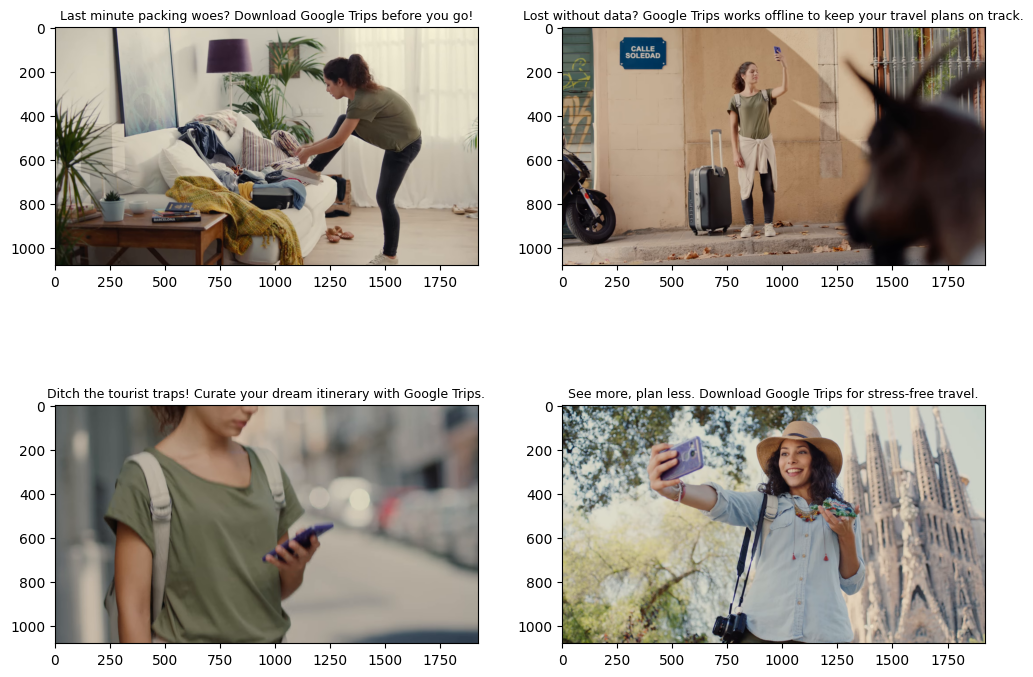

In [56]:
display_results(response_text2, clip)

### Observations

#### Better prompting shows the following effects on results
- Results have improved in quality
- Captions are more meaningful
- Thumbnail images and captions tell a better story

## Conclusion

- We just saw that Gemini 1.5 Pro has multi-modal capabilites, and can be used for video understanding.
- Results can be improved by better prompting with proper guidelines and expectations.